In [643]:
!pip install python-docx

In [644]:
from docx import Document
import re
import pandas as pd
import os
import numpy as np

# Data prepare

In [645]:
def extract_words_from_docx(file_path):
    with open(file_path, 'r') as file:
      text = file.read()
    return text

In [646]:
from collections import OrderedDict
from transformers import MPNetPreTrainedModel, MPNetModel, AutoTokenizer
import torch

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Definition of ESGify class because of custom,sentence-transformers like, mean pooling function and classifier head
class ESGify(MPNetPreTrainedModel):
    """Model for Classification ESG risks from text."""

    def __init__(self,config): #tuning only the head
        """
        """
        super().__init__(config)
        # Instantiate Parts of model
        self.mpnet = MPNetModel(config,add_pooling_layer=False)
        self.id2label =  config.id2label
        self.label2id =  config.label2id
        self.classifier = torch.nn.Sequential(OrderedDict([('norm',torch.nn.BatchNorm1d(768)),
                                                ('linear',torch.nn.Linear(768,512)),
                                                ('act',torch.nn.ReLU()),
                                                ('batch_n',torch.nn.BatchNorm1d(512)),
                                                ('drop_class', torch.nn.Dropout(0.2)),
                                                ('class_l',torch.nn.Linear(512 ,47))]))


    def forward(self, input_ids, attention_mask):
         # Feed input to mpnet model
        outputs = self.mpnet(input_ids=input_ids,
                             attention_mask=attention_mask)

        # mean pooling dataset and eed input to classifier to compute logits
        logits = self.classifier( mean_pooling(outputs['last_hidden_state'],attention_mask))

        # apply sigmoid
        logits  = 1.0 / (1.0 + torch.exp(-logits))
        return logits

In [647]:
model = ESGify.from_pretrained('ai-lab/ESGify')
tokenizer = AutoTokenizer.from_pretrained('ai-lab/ESGify')

In [648]:
print(model.id2label.values())

dict_values(['Legal Proceedings & Law Violations', 'Biodiversity', 'Communities Health and Safety', 'Land Acquisition and Resettlement (S)', 'Emergencies (Social)', 'Corporate Governance', 'Responsible Investment & Greenwashing', 'Not Relevant to ESG', 'Economic Crime', 'Emergencies (Environmental)', 'Hazardous Materials Management', 'Environmental Management', 'Landscape Transformation', 'Human Rights', 'Climate Risks', 'Labor Relations Management', 'Freedom of Association and Right to Organise', 'Employee Health and Safety', 'Surface Water Pollution', 'Animal Welfare', 'Water Consumption', 'Disclosure', 'Product Safety and Quality', 'Greenhouse Gas Emissions', 'Indigenous People', 'Cultural Heritage', 'Air Pollution', 'Waste Management', 'Soil and Groundwater Impact', 'Forced Labour', 'Wastewater Management', 'Natural Resources', 'Physical Impacts', 'Values and Ethics', 'Risk Management and Internal Control', 'Supply Chain (Environmental)', 'Supply Chain (Social)', 'Discrimination', 

In [649]:
df1 = pd.DataFrame(index = model.id2label.values(), columns = ['10'])
df1 = df1.fillna(10)
df1

,10
Legal Proceedings & Law Violations,10
Biodiversity,10
Communities Health and Safety,10
Land Acquisition and Resettlement (S),10
Emergencies (Social),10
Corporate Governance,10
Responsible Investment & Greenwashing,10
Not Relevant to ESG,10
Economic Crime,10
Emergencies (Environmental),10


In [650]:
folder_path = '/content/data/'
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        print(file_path)
        text = extract_words_from_docx(file_path)
        paragraphs = text.split('/n')
        max_res = np.zeros(47)
        for paragraph in paragraphs:
          texts = [paragraph]
          to_model = tokenizer.batch_encode_plus(
                  texts,
                  add_special_tokens=True,
                  max_length= 512,
                  return_token_type_ids=False,
                  padding="longest",
                  truncation=True,
                  return_attention_mask=True,
                  return_tensors='pt',
									         )
          results = model(**to_model)
          ress_1 = results.detach().numpy()
          max_res = np.maximum(max_res, ress_1[0])
        df1[file_path] = max_res

In [651]:
df1 = df1.drop(columns = {'10'})
df1

""
Legal Proceedings & Law Violations
Biodiversity
Communities Health and Safety
Land Acquisition and Resettlement (S)
Emergencies (Social)
Corporate Governance
Responsible Investment & Greenwashing
Not Relevant to ESG
Economic Crime
Emergencies (Environmental)


In [652]:
df1.shape

(47, 0)

In [653]:
#df1.to_csv("Weights_with_paragraphs_new.csv")

In [654]:
from google.colab import files

#files.download('Weights_with_paragraphs.csv')

In [655]:
df1 = pd.read_csv("Weights_with_paragraphs_new.csv")
df1.rename(columns={ 'Unnamed: 0' :  'index' }, inplace=True)
df1.set_index('index', inplace=True)
# df1.drop(columns = df1.columns[0])
df1 = df1.T
df1.reset_index(inplace=True)
df1.rename(columns={ 'index' :  'Company_name' }, inplace=True)
df1.reset_index(drop=True, inplace=True)
df1['Company_name'] = df1['Company_name'].apply(lambda name : name[len('/content/data/'):])
df1

index,Company_name,Legal Proceedings & Law Violations,Biodiversity,Communities Health and Safety,Land Acquisition and Resettlement (S),Emergencies (Social),Corporate Governance,Responsible Investment & Greenwashing,Not Relevant to ESG,Economic Crime,...,Discrimination,Minimum Age and Child Labour,Planning Limitations,Data Safety,Strategy Implementation,Energy Efficiency and Renewables,Land Acquisition and Resettlement (E),Supply Chain (Economic / Governance),Land Rehabilitation,Retrenchment
0,СЕГЕЖА инфа.txt,0.045125,0.094551,0.025876,0.040868,0.075061,0.566426,0.514729,0.495201,0.235149,...,0.374118,0.069972,0.078965,0.180511,0.024080,0.094233,0.108541,0.075870,0.059261,0.117523
1,САМОЛЁТ инфа.txt,0.025009,0.061903,0.020453,0.035260,0.043850,0.630309,0.440806,0.493231,0.149466,...,0.437850,0.055911,0.074751,0.171938,0.026611,0.093256,0.072581,0.081097,0.064717,0.087164
2,Лукойл инфа.txt,0.027974,0.062846,0.015628,0.032729,0.055892,0.549041,0.380366,0.544024,0.172322,...,0.348759,0.066491,0.073473,0.163080,0.023239,0.110797,0.078630,0.069863,0.062046,0.099246
3,ЭН+ ГРУП инфа.txt,0.022794,0.090075,0.015610,0.030713,0.056106,0.607297,0.400765,0.582579,0.172775,...,0.484575,0.074694,0.078245,0.199000,0.031634,0.094207,0.079795,0.062724,0.055306,0.084947
4,МЕЧЕЛ инфа.txt,0.023837,0.086233,0.019279,0.031943,0.066247,0.544013,0.451916,0.606429,0.192228,...,0.431164,0.094119,0.066355,0.230393,0.028222,0.146423,0.110235,0.071762,0.064342,0.084335
5,Аэрофлот инфа.txt,0.023541,0.055277,0.020064,0.027003,0.037927,0.473231,0.330453,0.537024,0.119924,...,0.371841,0.039103,0.054184,0.103961,0.024212,0.056720,0.074787,0.089417,0.048368,0.047178
6,Полюс инфа.txt,0.029651,0.061544,0.030379,0.026903,0.039365,0.552986,0.454973,0.570482,0.148577,...,0.340641,0.060605,0.064306,0.155836,0.019436,0.081202,0.063464,0.067147,0.043119,0.062543
7,Татнефть инфа.txt,0.027104,0.139767,0.016457,0.033366,0.105035,0.462689,0.375903,0.516913,0.178960,...,0.403494,0.112418,0.054712,0.251177,0.035685,0.155086,0.136433,0.075950,0.084478,0.120358
8,Транснефть инфа.txt,0.025848,0.066365,0.016379,0.027660,0.056751,0.473676,0.337067,0.646416,0.151827,...,0.437830,0.076602,0.052765,0.134401,0.026969,0.072367,0.064111,0.072693,0.049438,0.054992
9,ПИК инфа.txt,0.028719,0.093617,0.020887,0.037927,0.063723,0.563013,0.455897,0.580182,0.158557,...,0.415579,0.077204,0.088287,0.198868,0.028311,0.099311,0.087027,0.094098,0.050251,0.103554


In [656]:
df1 = df1.rename(index=lambda x: df1['Company_name'][x].lower().replace(' инфа.txt', '')).drop(columns = {'Company_name'})
df1

index,Legal Proceedings & Law Violations,Biodiversity,Communities Health and Safety,Land Acquisition and Resettlement (S),Emergencies (Social),Corporate Governance,Responsible Investment & Greenwashing,Not Relevant to ESG,Economic Crime,Emergencies (Environmental),...,Discrimination,Minimum Age and Child Labour,Planning Limitations,Data Safety,Strategy Implementation,Energy Efficiency and Renewables,Land Acquisition and Resettlement (E),Supply Chain (Economic / Governance),Land Rehabilitation,Retrenchment
сегежа,0.045125,0.094551,0.025876,0.040868,0.075061,0.566426,0.514729,0.495201,0.235149,0.217873,...,0.374118,0.069972,0.078965,0.180511,0.024080,0.094233,0.108541,0.075870,0.059261,0.117523
самолёт,0.025009,0.061903,0.020453,0.035260,0.043850,0.630309,0.440806,0.493231,0.149466,0.172215,...,0.437850,0.055911,0.074751,0.171938,0.026611,0.093256,0.072581,0.081097,0.064717,0.087164
лукойл,0.027974,0.062846,0.015628,0.032729,0.055892,0.549041,0.380366,0.544024,0.172322,0.196258,...,0.348759,0.066491,0.073473,0.163080,0.023239,0.110797,0.078630,0.069863,0.062046,0.099246
эн+ груп,0.022794,0.090075,0.015610,0.030713,0.056106,0.607297,0.400765,0.582579,0.172775,0.172992,...,0.484575,0.074694,0.078245,0.199000,0.031634,0.094207,0.079795,0.062724,0.055306,0.084947
мечел,0.023837,0.086233,0.019279,0.031943,0.066247,0.544013,0.451916,0.606429,0.192228,0.211642,...,0.431164,0.094119,0.066355,0.230393,0.028222,0.146423,0.110235,0.071762,0.064342,0.084335
аэрофлот,0.023541,0.055277,0.020064,0.027003,0.037927,0.473231,0.330453,0.537024,0.119924,0.103425,...,0.371841,0.039103,0.054184,0.103961,0.024212,0.056720,0.074787,0.089417,0.048368,0.047178
полюс,0.029651,0.061544,0.030379,0.026903,0.039365,0.552986,0.454973,0.570482,0.148577,0.129249,...,0.340641,0.060605,0.064306,0.155836,0.019436,0.081202,0.063464,0.067147,0.043119,0.062543
татнефть,0.027104,0.139767,0.016457,0.033366,0.105035,0.462689,0.375903,0.516913,0.178960,0.378207,...,0.403494,0.112418,0.054712,0.251177,0.035685,0.155086,0.136433,0.075950,0.084478,0.120358
транснефть,0.025848,0.066365,0.016379,0.027660,0.056751,0.473676,0.337067,0.646416,0.151827,0.200072,...,0.437830,0.076602,0.052765,0.134401,0.026969,0.072367,0.064111,0.072693,0.049438,0.054992
пик,0.028719,0.093617,0.020887,0.037927,0.063723,0.563013,0.455897,0.580182,0.158557,0.188869,...,0.415579,0.077204,0.088287,0.198868,0.028311,0.099311,0.087027,0.094098,0.050251,0.103554


In [657]:
df2 =  pd.read_excel("/content/RAEX_rating.xlsx").drop(columns = ['Код MOEX', 'Подотрасль', 'Год последней оцененной отчетности']).rename(columns = {'Название' : 'index'})
df2 = df2.set_index('index')
df2.index = df2.index.str.strip('«')
df2.index = df2.index.str.strip('»')
df2.index = df2.index.str.split('»').str[0]
df2 = df2.rename(index = lambda x: x.lower())
df2

,Y,ESG-рейтинг,E Rank,E-рейтинг,S Rank,S-рейтинг,G Rank,G-рейтинг
index,,,,,,,,
сбербанк,1,AA,2,AA,1,AAA,4,AAA
фосагро,2,AA,5,AA,3,AA,2,AAA
полюс,3,AA,1,AA,2,AA,14,AA
татнефть,4,AA,13,A,5,AA,6,AA
роснефть,5,AA,4,AA,22,A,5,AAA
...,...,...,...,...,...,...,...,...
новикомбанк,156,C,114,C,145,C,155-156,C
квадра,157-160,M,157-160,M,157-160,M,157-160,M
русская медная компания,157-160,M,157-160,M,157-160,M,157-160,M


In [658]:
df1.index

Index(['сегежа', 'самолёт', 'лукойл', 'эн+ груп', 'мечел', 'аэрофлот', 'полюс',
       'татнефть', 'транснефть', 'пик', 'сургутнефтегаз', 'ткс-холдинг',
       'россети', 'гмк норильский никель', 'икс 5 ритейл', 'газпром',
       'русагро', 'нлмк', 'вк', 'втб', 'сбербанк', 'русгидро', 'совкомфлот',
       'глобалтранс', 'магнит', 'роснефть', 'селигдар', 'группа позитив',
       'ммк', 'русал', 'фосагро', 'мтс', 'алроса', 'мосэнерго', 'северсталь',
       'интер рао', 'юнипро', 'банк санкт-петербург', 'мкб', 'новатэк',
       'московская биржа', 'афк система'],
      dtype='object')

In [659]:
df1 = df1.rename(index = {'икс 5 ритейл' : 'x5 group', 'вк' : 'vk', 'гмк норильский никель' : 'норильский никель', 'группа позитив' : 'positive technologies'})

In [660]:
df2 = df2.rename(index = {'афк «система' : 'афк система', 'аэрофлот - российские авиалинии' : 'аэрофлот', 'банк «санкт-петербург' : 'банк санкт-петербург', 'банк втб' : 'втб', 'globaltrans' : 'глобалтранс', 'московский кредитный банк' : 'мкб', 'магнитогорский металлургический комбинат (ммк)' : 'ммк', 'пао "мтс"' : 'мтс', 'группа компаний пик' : 'пик', 'сегежа групп': 'сегежа', 'гк «самолет' : 'самолёт', 'акционерная компания «алроса' : 'алроса', 'пао «селигдар' : 'селигдар'})
df2

,Y,ESG-рейтинг,E Rank,E-рейтинг,S Rank,S-рейтинг,G Rank,G-рейтинг
index,,,,,,,,
сбербанк,1,AA,2,AA,1,AAA,4,AAA
фосагро,2,AA,5,AA,3,AA,2,AAA
полюс,3,AA,1,AA,2,AA,14,AA
татнефть,4,AA,13,A,5,AA,6,AA
роснефть,5,AA,4,AA,22,A,5,AAA
...,...,...,...,...,...,...,...,...
новикомбанк,156,C,114,C,145,C,155-156,C
квадра,157-160,M,157-160,M,157-160,M,157-160,M
русская медная компания,157-160,M,157-160,M,157-160,M,157-160,M


In [661]:
for word in sorted(df2.index):
  print(word)

"каустик" (г. волгоград)
"нефтиса", нефтяная компания
"соликамскбумпром"
"титан", группа компаний (деревообработка)
en+ group
global ports
highland gold mining
nordgold
positive technologies
s7 airlines
vk
x5 group
аб «россия
агрохолдинг «степь
азбука вкуса
ак барс
акрон
алмазэргиэнбанк
алроса
альфа-банк
архангельский цбк
афк система
ашинский металлургический завод
аэрофлот
банк санкт-петербург
башкирская содовая компания
башнефть
вбрр
вкусвилл
втб
вымпелком
высочайший
газ
газпром
газпром нефть
газпромбанк
гиперглобус
глобалтранс
группа «эталон
группа компаний «азот
группа лср
группа полипластик
группа синара
группа черкизово
детский мир
евраз
зарубежнефть
золоторудная компания павлик
илим
инарктика
интер рао
интернет решения
иркутская нефтяная компания
камаз
карелия палп
квадра
киви банк
кордиант
корпорация всмпо-ависма
красноярский завод цветных металлов имени в.н. гулидова
кузбассразрезуголь
куйбышевазот
лента
лукойл
м.видео-эльдорадо
магнит
мегафон
международный аэропорт шереметьев

In [662]:
merged_df = df1.merge(df2, left_index=True, right_index=True)

In [663]:
merged_df

,Legal Proceedings & Law Violations,Biodiversity,Communities Health and Safety,Land Acquisition and Resettlement (S),Emergencies (Social),Corporate Governance,Responsible Investment & Greenwashing,Not Relevant to ESG,Economic Crime,Emergencies (Environmental),...,Land Rehabilitation,Retrenchment,Y,ESG-рейтинг,E Rank,E-рейтинг,S Rank,S-рейтинг,G Rank,G-рейтинг
сегежа,0.045125,0.094551,0.025876,0.040868,0.075061,0.566426,0.514729,0.495201,0.235149,0.217873,...,0.059261,0.117523,55,B,56,CCC,50,BB,60,BB
самолёт,0.025009,0.061903,0.020453,0.035260,0.043850,0.630309,0.440806,0.493231,0.149466,0.172215,...,0.064717,0.087164,52,BB,60,CCC,47,BB,43,BBB
лукойл,0.027974,0.062846,0.015628,0.032729,0.055892,0.549041,0.380366,0.544024,0.172322,0.196258,...,0.062046,0.099246,17,A,19,BBB,17,A,12,AA
мечел,0.023837,0.086233,0.019279,0.031943,0.066247,0.544013,0.451916,0.606429,0.192228,0.211642,...,0.064342,0.084335,112,CC,117,C,123,CC,95,B
аэрофлот,0.023541,0.055277,0.020064,0.027003,0.037927,0.473231,0.330453,0.537024,0.119924,0.103425,...,0.048368,0.047178,30,BBB,37,B,23,A,28,A
полюс,0.029651,0.061544,0.030379,0.026903,0.039365,0.552986,0.454973,0.570482,0.148577,0.129249,...,0.043119,0.062543,3,AA,1,AA,2,AA,14,AA
татнефть,0.027104,0.139767,0.016457,0.033366,0.105035,0.462689,0.375903,0.516913,0.178960,0.378207,...,0.084478,0.120358,4,AA,13,A,5,AA,6,AA
транснефть,0.025848,0.066365,0.016379,0.027660,0.056751,0.473676,0.337067,0.646416,0.151827,0.200072,...,0.049438,0.054992,94,CCC,82,CC,76,CCC,115,CCC
пик,0.028719,0.093617,0.020887,0.037927,0.063723,0.563013,0.455897,0.580182,0.158557,0.188869,...,0.050251,0.103554,134,CC,133-134,C,149,C,120,CCC
сургутнефтегаз,0.031649,0.094598,0.029158,0.046756,0.081039,0.666742,0.503350,0.532149,0.233820,0.225991,...,0.069793,0.102514,72,CCC,39,B,110,CC,102,B


In [664]:
set1 = set(df1.index)
set2 = set(df2.index)
result = set1.difference(set2)
result

{'мосэнерго', 'ткс-холдинг', 'эн+ груп'}

In [665]:
#merged_df.to_csv("Weights_with_rating.csv")

In [666]:
from google.colab import files

#files.download('Weights_with_rating.csv')

In [667]:
points_dict = {'C' : 1/18, 'CC' : 1/6, 'CCC' : 5/18, 'B' : 7/18, 'BB' : 1/2, 'BBB' : 11/18, 'A' : 13/18, 'AA' : 5/6, 'AAA' : 17/18}
merged_df['ESG-рейтинг'] = merged_df['ESG-рейтинг'].replace(points_dict)
merged_df['E-рейтинг'] = merged_df['E-рейтинг'].replace(points_dict)
merged_df['S-рейтинг'] = merged_df['S-рейтинг'].replace(points_dict)
merged_df['G-рейтинг'] = merged_df['G-рейтинг'].replace(points_dict)
merged_df

,Legal Proceedings & Law Violations,Biodiversity,Communities Health and Safety,Land Acquisition and Resettlement (S),Emergencies (Social),Corporate Governance,Responsible Investment & Greenwashing,Not Relevant to ESG,Economic Crime,Emergencies (Environmental),...,Land Rehabilitation,Retrenchment,Y,ESG-рейтинг,E Rank,E-рейтинг,S Rank,S-рейтинг,G Rank,G-рейтинг
сегежа,0.045125,0.094551,0.025876,0.040868,0.075061,0.566426,0.514729,0.495201,0.235149,0.217873,...,0.059261,0.117523,55,0.388889,56,0.277778,50,0.500000,60,0.500000
самолёт,0.025009,0.061903,0.020453,0.035260,0.043850,0.630309,0.440806,0.493231,0.149466,0.172215,...,0.064717,0.087164,52,0.500000,60,0.277778,47,0.500000,43,0.611111
лукойл,0.027974,0.062846,0.015628,0.032729,0.055892,0.549041,0.380366,0.544024,0.172322,0.196258,...,0.062046,0.099246,17,0.722222,19,0.611111,17,0.722222,12,0.833333
мечел,0.023837,0.086233,0.019279,0.031943,0.066247,0.544013,0.451916,0.606429,0.192228,0.211642,...,0.064342,0.084335,112,0.166667,117,0.055556,123,0.166667,95,0.388889
аэрофлот,0.023541,0.055277,0.020064,0.027003,0.037927,0.473231,0.330453,0.537024,0.119924,0.103425,...,0.048368,0.047178,30,0.611111,37,0.388889,23,0.722222,28,0.722222
полюс,0.029651,0.061544,0.030379,0.026903,0.039365,0.552986,0.454973,0.570482,0.148577,0.129249,...,0.043119,0.062543,3,0.833333,1,0.833333,2,0.833333,14,0.833333
татнефть,0.027104,0.139767,0.016457,0.033366,0.105035,0.462689,0.375903,0.516913,0.178960,0.378207,...,0.084478,0.120358,4,0.833333,13,0.722222,5,0.833333,6,0.833333
транснефть,0.025848,0.066365,0.016379,0.027660,0.056751,0.473676,0.337067,0.646416,0.151827,0.200072,...,0.049438,0.054992,94,0.277778,82,0.166667,76,0.277778,115,0.277778
пик,0.028719,0.093617,0.020887,0.037927,0.063723,0.563013,0.455897,0.580182,0.158557,0.188869,...,0.050251,0.103554,134,0.166667,133-134,0.055556,149,0.055556,120,0.277778
сургутнефтегаз,0.031649,0.094598,0.029158,0.046756,0.081039,0.666742,0.503350,0.532149,0.233820,0.225991,...,0.069793,0.102514,72,0.277778,39,0.388889,110,0.166667,102,0.388889


In [668]:
#merged_df.to_csv("Weights_with_rating_number.csv")

In [669]:
from google.colab import files

#files.download('Weights_with_rating.csv')

In [670]:
from google.colab import drive
#drive.mount('/content/drive')

In [671]:
df1

index,Legal Proceedings & Law Violations,Biodiversity,Communities Health and Safety,Land Acquisition and Resettlement (S),Emergencies (Social),Corporate Governance,Responsible Investment & Greenwashing,Not Relevant to ESG,Economic Crime,Emergencies (Environmental),...,Discrimination,Minimum Age and Child Labour,Planning Limitations,Data Safety,Strategy Implementation,Energy Efficiency and Renewables,Land Acquisition and Resettlement (E),Supply Chain (Economic / Governance),Land Rehabilitation,Retrenchment
сегежа,0.045125,0.094551,0.025876,0.040868,0.075061,0.566426,0.514729,0.495201,0.235149,0.217873,...,0.374118,0.069972,0.078965,0.180511,0.024080,0.094233,0.108541,0.075870,0.059261,0.117523
самолёт,0.025009,0.061903,0.020453,0.035260,0.043850,0.630309,0.440806,0.493231,0.149466,0.172215,...,0.437850,0.055911,0.074751,0.171938,0.026611,0.093256,0.072581,0.081097,0.064717,0.087164
лукойл,0.027974,0.062846,0.015628,0.032729,0.055892,0.549041,0.380366,0.544024,0.172322,0.196258,...,0.348759,0.066491,0.073473,0.163080,0.023239,0.110797,0.078630,0.069863,0.062046,0.099246
эн+ груп,0.022794,0.090075,0.015610,0.030713,0.056106,0.607297,0.400765,0.582579,0.172775,0.172992,...,0.484575,0.074694,0.078245,0.199000,0.031634,0.094207,0.079795,0.062724,0.055306,0.084947
мечел,0.023837,0.086233,0.019279,0.031943,0.066247,0.544013,0.451916,0.606429,0.192228,0.211642,...,0.431164,0.094119,0.066355,0.230393,0.028222,0.146423,0.110235,0.071762,0.064342,0.084335
аэрофлот,0.023541,0.055277,0.020064,0.027003,0.037927,0.473231,0.330453,0.537024,0.119924,0.103425,...,0.371841,0.039103,0.054184,0.103961,0.024212,0.056720,0.074787,0.089417,0.048368,0.047178
полюс,0.029651,0.061544,0.030379,0.026903,0.039365,0.552986,0.454973,0.570482,0.148577,0.129249,...,0.340641,0.060605,0.064306,0.155836,0.019436,0.081202,0.063464,0.067147,0.043119,0.062543
татнефть,0.027104,0.139767,0.016457,0.033366,0.105035,0.462689,0.375903,0.516913,0.178960,0.378207,...,0.403494,0.112418,0.054712,0.251177,0.035685,0.155086,0.136433,0.075950,0.084478,0.120358
транснефть,0.025848,0.066365,0.016379,0.027660,0.056751,0.473676,0.337067,0.646416,0.151827,0.200072,...,0.437830,0.076602,0.052765,0.134401,0.026969,0.072367,0.064111,0.072693,0.049438,0.054992
пик,0.028719,0.093617,0.020887,0.037927,0.063723,0.563013,0.455897,0.580182,0.158557,0.188869,...,0.415579,0.077204,0.088287,0.198868,0.028311,0.099311,0.087027,0.094098,0.050251,0.103554


In [672]:
from google.colab import files

#files.download('weights_with_rating.csv')

In [673]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             make_scorer, precision_score, recall_score,
                             roc_auc_score)
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [674]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [675]:
merged_df

,Legal Proceedings & Law Violations,Biodiversity,Communities Health and Safety,Land Acquisition and Resettlement (S),Emergencies (Social),Corporate Governance,Responsible Investment & Greenwashing,Not Relevant to ESG,Economic Crime,Emergencies (Environmental),...,Land Rehabilitation,Retrenchment,Y,ESG-рейтинг,E Rank,E-рейтинг,S Rank,S-рейтинг,G Rank,G-рейтинг
сегежа,0.045125,0.094551,0.025876,0.040868,0.075061,0.566426,0.514729,0.495201,0.235149,0.217873,...,0.059261,0.117523,55,0.388889,56,0.277778,50,0.500000,60,0.500000
самолёт,0.025009,0.061903,0.020453,0.035260,0.043850,0.630309,0.440806,0.493231,0.149466,0.172215,...,0.064717,0.087164,52,0.500000,60,0.277778,47,0.500000,43,0.611111
лукойл,0.027974,0.062846,0.015628,0.032729,0.055892,0.549041,0.380366,0.544024,0.172322,0.196258,...,0.062046,0.099246,17,0.722222,19,0.611111,17,0.722222,12,0.833333
мечел,0.023837,0.086233,0.019279,0.031943,0.066247,0.544013,0.451916,0.606429,0.192228,0.211642,...,0.064342,0.084335,112,0.166667,117,0.055556,123,0.166667,95,0.388889
аэрофлот,0.023541,0.055277,0.020064,0.027003,0.037927,0.473231,0.330453,0.537024,0.119924,0.103425,...,0.048368,0.047178,30,0.611111,37,0.388889,23,0.722222,28,0.722222
полюс,0.029651,0.061544,0.030379,0.026903,0.039365,0.552986,0.454973,0.570482,0.148577,0.129249,...,0.043119,0.062543,3,0.833333,1,0.833333,2,0.833333,14,0.833333
татнефть,0.027104,0.139767,0.016457,0.033366,0.105035,0.462689,0.375903,0.516913,0.178960,0.378207,...,0.084478,0.120358,4,0.833333,13,0.722222,5,0.833333,6,0.833333
транснефть,0.025848,0.066365,0.016379,0.027660,0.056751,0.473676,0.337067,0.646416,0.151827,0.200072,...,0.049438,0.054992,94,0.277778,82,0.166667,76,0.277778,115,0.277778
пик,0.028719,0.093617,0.020887,0.037927,0.063723,0.563013,0.455897,0.580182,0.158557,0.188869,...,0.050251,0.103554,134,0.166667,133-134,0.055556,149,0.055556,120,0.277778
сургутнефтегаз,0.031649,0.094598,0.029158,0.046756,0.081039,0.666742,0.503350,0.532149,0.233820,0.225991,...,0.069793,0.102514,72,0.277778,39,0.388889,110,0.166667,102,0.388889


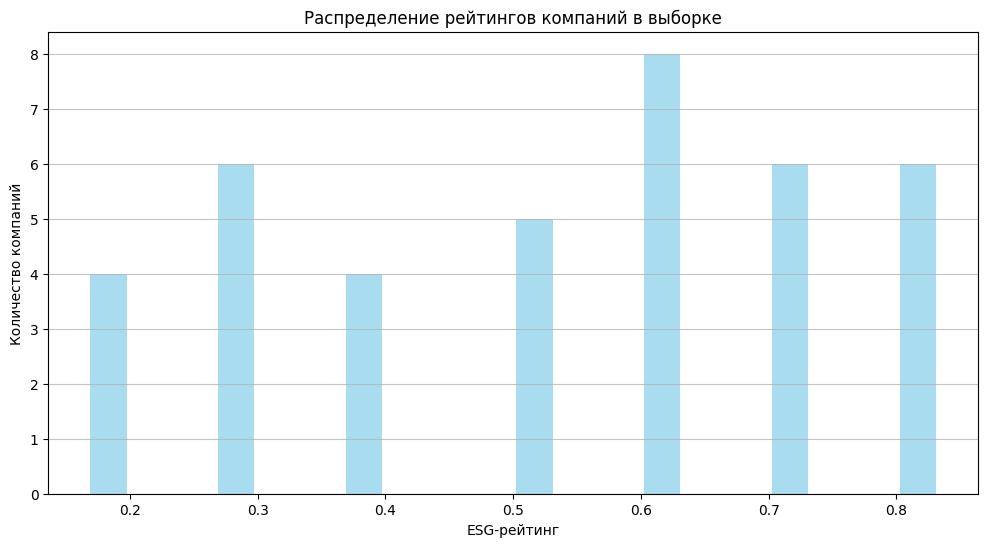

In [676]:
plt.figure(figsize=(12, 6))
plt.hist(merged_df['ESG-рейтинг'], bins=20, color='skyblue', alpha=0.7, rwidth=0.85)
plt.title('Распределение рейтингов компаний в выборке')
plt.xlabel('ESG-рейтинг')
plt.ylabel('Количество компаний')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Common ESG rating prediction

In [677]:
target = 'ESG-рейтинг'
print(merged_df.columns)
X = merged_df.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'E-рейтинг', 'S-рейтинг', 'G-рейтинг'])
y = merged_df[target]

rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True, stratify=y)


y_test[0].values

Index(['Legal Proceedings & Law Violations', 'Biodiversity',
       'Communities Health and Safety',
       'Land Acquisition and Resettlement (S)', 'Emergencies (Social)',
       'Corporate Governance', 'Responsible Investment & Greenwashing',
       'Not Relevant to ESG', 'Economic Crime', 'Emergencies (Environmental)',
       'Hazardous Materials Management', 'Environmental Management',
       'Landscape Transformation', 'Human Rights', 'Climate Risks',
       'Labor Relations Management',
       'Freedom of Association and Right to Organise',
       'Employee Health and Safety', 'Surface Water Pollution',
       'Animal Welfare', 'Water Consumption', 'Disclosure',
       'Product Safety and Quality', 'Greenhouse Gas Emissions',
       'Indigenous People', 'Cultural Heritage', 'Air Pollution',
       'Waste Management', 'Soil and Groundwater Impact', 'Forced Labour',
       'Wastewater Management', 'Natural Resources', 'Physical Impacts',
       'Values and Ethics', 'Risk Management

array([0.38888889, 0.72222222, 0.61111111, 0.72222222, 0.16666667,
       0.27777778, 0.61111111, 0.27777778, 0.5       , 0.83333333])

In [678]:
sample_y_test = y_test[-1]
print(sample_y_test.values)

[0.38888889 0.61111111 0.27777778 0.5        0.61111111 0.27777778
 0.16666667 0.72222222 0.83333333 0.83333333]


In [679]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'RAEX values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,RAEX values,0,0,0.388889,0.611111,0.277778,0.5,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333


In [680]:
def add_row_res(model, mse, rsq, y_pred):
    return pd.DataFrame({'Model': model, 'MSE': mse, 'R^2 score': rsq, **dict(zip(compare_table.columns[3:], y_pred))}, index=[0])

In [681]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])

    # print(y_pred)
    # print(y_test)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.28298430404883124
R^2 Score: -4.932865370229651


In [682]:
%time

model = RandomForestRegressor(random_state=42)
#model.fit(X_train, y_train)
param_grid = {
    'n_estimators': [50],
    'max_depth': [None],
    'min_samples_split': [20],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#print("Лучшие параметры: ", grid_search.best_params_)
#Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
#Mean Squared Error: 0.05508845985402971
for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])

    # Оценка модели
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mean Squared Error: 0.0528779256641844
R^2 Score: -0.11586787097248656


In [683]:
param_grid = {
    'n_neighbors': [19],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров

# Вывод лучших параметров
#print("Лучшие параметры: ", grid_search.best_params_)
# Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 19, 'weights': 'uniform'}
# Mean Squared Error: 0.04452367110107953

# Оценка модели
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])

    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.05406449847816423
R^2 Score: -0.052698167483486325


In [684]:
# Определение параметров для поиска
param_grid = {
    'max_depth': [None],
    'min_samples_split': [20],
    'min_samples_leaf': [9],
    'max_features': ['sqrt'],
}

# Создание модели
model = DecisionTreeRegressor(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров


# Вывод лучших параметров
# print("Лучшие параметры: ", grid_search.best_params_)

# Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 20}
# Mean Squared Error: 0.050617283950617285
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    # Предсказание на тестовых данных с использованием лучшей модели
    y_pred = grid_search.predict(X_test[i])
    # Оценка модели
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.06432171816787202
R^2 Score: -0.2524180700955849
[0.61111111 0.43162393 0.43162393 0.43162393 0.43162393 0.43162393
 0.43162393 0.43162393 0.43162393 0.43162393]


In [685]:
#Проверка на дурака - какая ошибка будет у константного решения (матожидание = 0.5+-eps)
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [686]:
esg_table = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,RAEX values,0,0,0.388889,0.611111,0.277778,0.500000,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333
1,LinReg,0.282984,-4.932865,0.870943,-0.026127,-0.453050,0.025419,0.565073,-0.837588,0.215785,2.081880,0.482407,1.115623
2,RandomForest,0.052878,-0.115868,0.519299,0.514601,0.509806,0.557664,0.524954,0.505151,0.562756,0.529197,0.524966,0.525025
3,KNN,0.054064,-0.052698,0.535088,0.505848,0.482456,0.558480,0.500000,0.500000,0.558480,0.511696,0.505848,0.523392
4,DecisionTree,0.064322,-0.252418,0.611111,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624
5,CoolMonkey,0.051674,-0.006154,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


Теперь попробуем обучить для каждой из букв E, S, G

# E rating

In [687]:
target = 'E-рейтинг'
print(merged_df.columns)
X = merged_df.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'ESG-рейтинг', 'S-рейтинг', 'G-рейтинг'])
y = merged_df[target]

rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True)


y

Index(['Legal Proceedings & Law Violations', 'Biodiversity',
       'Communities Health and Safety',
       'Land Acquisition and Resettlement (S)', 'Emergencies (Social)',
       'Corporate Governance', 'Responsible Investment & Greenwashing',
       'Not Relevant to ESG', 'Economic Crime', 'Emergencies (Environmental)',
       'Hazardous Materials Management', 'Environmental Management',
       'Landscape Transformation', 'Human Rights', 'Climate Risks',
       'Labor Relations Management',
       'Freedom of Association and Right to Organise',
       'Employee Health and Safety', 'Surface Water Pollution',
       'Animal Welfare', 'Water Consumption', 'Disclosure',
       'Product Safety and Quality', 'Greenhouse Gas Emissions',
       'Indigenous People', 'Cultural Heritage', 'Air Pollution',
       'Waste Management', 'Soil and Groundwater Impact', 'Forced Labour',
       'Wastewater Management', 'Natural Resources', 'Physical Impacts',
       'Values and Ethics', 'Risk Management

сегежа                   0.277778
самолёт                  0.277778
лукойл                   0.611111
мечел                    0.055556
аэрофлот                 0.388889
полюс                    0.833333
татнефть                 0.722222
транснефть               0.166667
пик                      0.055556
сургутнефтегаз           0.388889
россети                  0.388889
норильский никель        0.722222
x5 group                 0.611111
газпром                  0.500000
русагро                  0.055556
нлмк                     0.500000
vk                       0.388889
втб                      0.055556
сбербанк                 0.833333
русгидро                 0.500000
совкомфлот               0.166667
глобалтранс              0.166667
магнит                   0.277778
роснефть                 0.833333
селигдар                 0.277778
positive technologies    0.055556
ммк                      0.722222
русал                    0.722222
фосагро                  0.833333
мтс           

In [688]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'E values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0,0,0.833333,0.722222,0.166667,0.277778,0.833333,0.055556,0.5,0.5,0.277778,0.722222


In [689]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])

    # print(y_pred)
    # print(y_test)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.6147851975885477
R^2 Score: -9.273566557213819


In [690]:
%time
print(mse)
model = RandomForestRegressor(random_state=42)
#model.fit(X_train, y_train)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 7],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [25],
    'max_depth': [None],
    'min_samples_split': [15],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#print("Лучшие параметры: ", grid_search.best_params_)
#Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
#Mean Squared Error: 0.05508845985402971
for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    y_pred = grid_search.predict(X_test[i])
    print(mse)
    # Оценка модели
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
[1.0612033537994645, 0.4931666798704956, 0.3193159926238077, 0.4836100610538841, 0.557536965483411, 0.6993635694557818, 0.8493536500958733, 0.8416563868315239, 0.34074697950353156, 0.5018983371677024]
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}
[1.0612033537994645, 0.4931666798704956, 0.3193159926238077, 0.4836100610538841, 0.557536965483411, 0.6993635694557818, 0.8493536500958733, 0.8416563868315239, 0.34074697950353156, 0.5018983371677024]
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}
[0.09519665580963295, 0.4931666798704956, 0.3193159926238077, 0.4836100610538841, 0.557536965483411, 0.6993635694557818, 0.8493536500958733, 0.8416563868315239, 0.34074697950353156, 0.5018983371677024]
Лучшие параметры:  {'b

In [691]:
param_grid_try = {
    'n_neighbors': [5, 10, 15, 20, 25, 30, 40, 50, 70, 100],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'seuclidean', 'mahalanobis', 'wminkowski'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров

# Вывод лучших параметров
#print("Лучшие параметры: ", grid_search.best_params_)
# Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 19, 'weights': 'uniform'}
# Mean Squared Error: 0.04452367110107953

# Оценка модели
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    y_pred = grid_search.predict(X_test[i])

    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Mean Squared Error: 0.0859104938271605
R^2 Score: -0.18145161290322598


In [692]:
# Определение параметров для поиска
param_grid_try = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': [None],
}
param_grid = {
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'max_features': [None],
}

# Создание модели
model = DecisionTreeRegressor(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров


# Вывод лучших параметров
# print("Лучшие параметры: ", grid_search.best_params_)

# Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 20}
# Mean Squared Error: 0.050617283950617285
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    # Предсказание на тестовых данных с использованием лучшей модели
    y_pred = grid_search.predict(X_test[i])
    # Оценка модели
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  

In [693]:
#Проверка на дурака - какая ошибка будет у константного решения (матожидание = 0.5+-eps)
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [694]:
E_table = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0,0,0.833333,0.722222,0.166667,0.277778,0.833333,0.055556,0.500000,0.500000,0.277778,0.722222
1,LinReg,0.614785,-9.273567,1.068549,-1.041066,-0.040120,0.620831,0.217229,0.982204,0.102848,0.132288,0.154770,1.106529
2,RandomForest,0.08021,-0.284653,0.386852,0.445080,0.375057,0.405353,0.460355,0.539516,0.437048,0.378653,0.470260,0.417812
3,KNN,0.08591,-0.181452,0.344444,0.416667,0.400000,0.366667,0.394444,0.388889,0.422222,0.338889,0.377778,0.377778
4,DecisionTree,0.091805,-0.262519,0.527778,0.420635,0.111111,0.420635,0.111111,0.111111,0.420635,0.103175,0.420635,0.759259
5,CoolMonkey,0.075328,-0.035925,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


# S rating

In [695]:
target = 'S-рейтинг'
print(merged_df.columns)
X = merged_df.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'ESG-рейтинг', 'E-рейтинг', 'G-рейтинг'])
y = merged_df[target]
rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True)


y_test[-1].values

Index(['Legal Proceedings & Law Violations', 'Biodiversity',
       'Communities Health and Safety',
       'Land Acquisition and Resettlement (S)', 'Emergencies (Social)',
       'Corporate Governance', 'Responsible Investment & Greenwashing',
       'Not Relevant to ESG', 'Economic Crime', 'Emergencies (Environmental)',
       'Hazardous Materials Management', 'Environmental Management',
       'Landscape Transformation', 'Human Rights', 'Climate Risks',
       'Labor Relations Management',
       'Freedom of Association and Right to Organise',
       'Employee Health and Safety', 'Surface Water Pollution',
       'Animal Welfare', 'Water Consumption', 'Disclosure',
       'Product Safety and Quality', 'Greenhouse Gas Emissions',
       'Indigenous People', 'Cultural Heritage', 'Air Pollution',
       'Waste Management', 'Soil and Groundwater Impact', 'Forced Labour',
       'Wastewater Management', 'Natural Resources', 'Physical Impacts',
       'Values and Ethics', 'Risk Management

array([0.83333333, 0.83333333, 0.27777778, 0.72222222, 0.94444444,
       0.27777778, 0.38888889, 0.61111111, 0.61111111, 0.83333333])

In [696]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'S values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,S values,0,0,0.833333,0.833333,0.277778,0.722222,0.944444,0.277778,0.388889,0.611111,0.611111,0.833333


In [697]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])

    # print(y_pred)
    # print(y_test)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.5537179492874631
R^2 Score: -10.481536425232354


In [698]:
%time
print(mse)
model = RandomForestRegressor(random_state=42)
#model.fit(X_train, y_train)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 7],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [25],
    'max_depth': [None],
    'min_samples_split': [15],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#print("Лучшие параметры: ", grid_search.best_params_)
#Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
#Mean Squared Error: 0.05508845985402971
for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    y_pred = grid_search.predict(X_test[i])
    print(mse)
    # Оценка модели
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
[1.3257937318203061, 0.3315037447141355, 0.3387809888007506, 0.4763872368196053, 0.33160030386408795, 0.3547795458087758, 0.7283360982036118, 0.5749891698202255, 0.49234356162757076, 0.5826651113955611]
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}
[1.3257937318203061, 0.3315037447141355, 0.3387809888007506, 0.4763872368196053, 0.33160030386408795, 0.3547795458087758, 0.7283360982036118, 0.5749891698202255, 0.49234356162757076, 0.5826651113955611]
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}
[0.05695521080295525, 0.3315037447141355, 0.3387809888007506, 0.4763872368196053, 0.33160030386408795, 0.3547795458087758, 0.7283360982036118, 0.5749891698202255, 0.49234356162757076, 0.5826651113955611]
Лучшие параметры

In [699]:
param_grid_try = {
    'n_neighbors': [5, 10, 15, 20, 25, 30, 40, 50, 70, 100],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'seuclidean', 'mahalanobis', 'wminkowski'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров

# Вывод лучших параметров
#print("Лучшие параметры: ", grid_search.best_params_)
# Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 19, 'weights': 'uniform'}
# Mean Squared Error: 0.04452367110107953

# Оценка модели
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    y_pred = grid_search.predict(X_test[i])

    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Mean Squared Error: 0.07841975308641976
R^2 Score: -0.4568807339449543


In [700]:
# Определение параметров для поиска
param_grid_try = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': [None],
}
param_grid = {
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'max_features': [None],
}

# Создание модели
model = DecisionTreeRegressor(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров


# Вывод лучших параметров
# print("Лучшие параметры: ", grid_search.best_params_)

# Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 20}
# Mean Squared Error: 0.050617283950617285
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    # Предсказание на тестовых данных с использованием лучшей модели
    y_pred = grid_search.predict(X_test[i])
    # Оценка модели
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  

In [701]:
#Проверка на дурака - какая ошибка будет у константного решения (матожидание = 0.5+-eps)
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [702]:
S_table = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,S values,0,0,0.833333,0.833333,0.277778,0.722222,0.944444,0.277778,0.388889,0.611111,0.611111,0.833333
1,LinReg,0.553718,-10.481536,0.991731,-0.792910,0.700871,0.552350,0.415192,0.554428,0.379476,-0.380485,-0.409160,1.587046
2,RandomForest,0.07727,-0.499838,0.467122,0.471644,0.466143,0.429692,0.406613,0.507345,0.561025,0.479517,0.517412,0.501363
3,KNN,0.07842,-0.456881,0.472222,0.516667,0.494444,0.461111,0.500000,0.505556,0.544444,0.450000,0.483333,0.483333
4,DecisionTree,0.118748,-1.206093,0.333333,0.574074,0.333333,0.416667,0.333333,0.333333,0.769841,0.333333,0.574074,0.416667
5,CoolMonkey,0.062538,-0.161835,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


# G rating

In [703]:
target = 'G-рейтинг'
print(merged_df.columns)
X = merged_df.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'ESG-рейтинг', 'E-рейтинг', 'S-рейтинг'])
y = merged_df[target]
rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True)


y_test[-1].values

Index(['Legal Proceedings & Law Violations', 'Biodiversity',
       'Communities Health and Safety',
       'Land Acquisition and Resettlement (S)', 'Emergencies (Social)',
       'Corporate Governance', 'Responsible Investment & Greenwashing',
       'Not Relevant to ESG', 'Economic Crime', 'Emergencies (Environmental)',
       'Hazardous Materials Management', 'Environmental Management',
       'Landscape Transformation', 'Human Rights', 'Climate Risks',
       'Labor Relations Management',
       'Freedom of Association and Right to Organise',
       'Employee Health and Safety', 'Surface Water Pollution',
       'Animal Welfare', 'Water Consumption', 'Disclosure',
       'Product Safety and Quality', 'Greenhouse Gas Emissions',
       'Indigenous People', 'Cultural Heritage', 'Air Pollution',
       'Waste Management', 'Soil and Groundwater Impact', 'Forced Labour',
       'Wastewater Management', 'Natural Resources', 'Physical Impacts',
       'Values and Ethics', 'Risk Management

array([0.83333333, 0.83333333, 0.38888889, 0.83333333, 0.94444444,
       0.38888889, 0.72222222, 0.72222222, 0.61111111, 0.72222222])

In [704]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'G values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,G values,0,0,0.833333,0.833333,0.388889,0.833333,0.944444,0.388889,0.722222,0.722222,0.611111,0.722222


In [705]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])

    # print(y_pred)
    # print(y_test)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.34092760993716575
R^2 Score: -7.565274601716948


In [706]:
%time
print(mse)
model = RandomForestRegressor(random_state=42)
#model.fit(X_train, y_train)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 7],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [25],
    'max_depth': [None],
    'min_samples_split': [15],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#print("Лучшие параметры: ", grid_search.best_params_)
#Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
#Mean Squared Error: 0.05508845985402971
for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    y_pred = grid_search.predict(X_test[i])
    print(mse)
    # Оценка модели
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs
[1.101562613502096, 0.1268108353052831, 0.23043726994118846, 0.2328321312807607, 0.14442695890010837, 0.3111689862572564, 0.22978546304221106, 0.411899581053898, 0.20241259908727716, 0.4179396610015781]
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}
[1.101562613502096, 0.1268108353052831, 0.23043726994118846, 0.2328321312807607, 0.14442695890010837, 0.3111689862572564, 0.22978546304221106, 0.411899581053898, 0.20241259908727716, 0.4179396610015781]
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 25}
[0.06598366813999863, 0.1268108353052831, 0.23043726994118846, 0.2328321312807607, 0.14442695890010837, 0.3111689862572564, 0.22978546304221106, 0.411899581053898, 0.20241259908727716, 0.4179396610015781]
Лучшие параметр

In [707]:
param_grid_try = {
    'n_neighbors': [5, 10, 15, 20, 25, 30, 40, 50, 70, 100],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'seuclidean', 'mahalanobis', 'wminkowski'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров

# Вывод лучших параметров
#print("Лучшие параметры: ", grid_search.best_params_)
# Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 19, 'weights': 'uniform'}
# Mean Squared Error: 0.04452367110107953

# Оценка модели
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    y_pred = grid_search.predict(X_test[i])

    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Mean Squared Error: 0.03701851851851852
R^2 Score: -0.17128906249999987


In [708]:
# Определение параметров для поиска
param_grid_try = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 5],
    'max_features': [None],
}
param_grid = {
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'max_features': [None],
}

# Создание модели
model = DecisionTreeRegressor(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров


# Вывод лучших параметров
# print("Лучшие параметры: ", grid_search.best_params_)

# Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 20}
# Mean Squared Error: 0.050617283950617285
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    # Предсказание на тестовых данных с использованием лучшей модели
    y_pred = grid_search.predict(X_test[i])
    # Оценка модели
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Лучшие параметры:  

In [709]:
#Проверка на дурака - какая ошибка будет у константного решения (матожидание = 0.5+-eps)
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [710]:
G_table = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,G values,0,0,0.833333,0.833333,0.388889,0.833333,0.944444,0.388889,0.722222,0.722222,0.611111,0.722222
1,LinReg,0.340928,-7.565275,1.171496,-0.626145,0.696618,0.681067,0.752182,0.261629,0.493057,0.487688,-0.031907,1.837089
2,RandomForest,0.052078,-0.396718,0.709722,0.542940,0.618692,0.559932,0.636163,0.620664,0.661397,0.674003,0.534581,0.617799
3,KNN,0.037019,-0.171289,0.600000,0.638889,0.627778,0.616667,0.633333,0.605556,0.650000,0.611111,0.594444,0.611111
4,DecisionTree,0.051101,-0.616874,0.611111,0.888889,0.888889,0.888889,0.907407,0.500000,0.500000,0.500000,0.500000,0.438272
5,CoolMonkey,0.057205,-0.81,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


# Summary ESG

In [711]:
E_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0,0,0.833333,0.722222,0.166667,0.277778,0.833333,0.055556,0.500000,0.500000,0.277778,0.722222
1,LinReg,0.614785,-9.273567,1.068549,-1.041066,-0.040120,0.620831,0.217229,0.982204,0.102848,0.132288,0.154770,1.106529
2,RandomForest,0.08021,-0.284653,0.386852,0.445080,0.375057,0.405353,0.460355,0.539516,0.437048,0.378653,0.470260,0.417812
3,KNN,0.08591,-0.181452,0.344444,0.416667,0.400000,0.366667,0.394444,0.388889,0.422222,0.338889,0.377778,0.377778
4,DecisionTree,0.091805,-0.262519,0.527778,0.420635,0.111111,0.420635,0.111111,0.111111,0.420635,0.103175,0.420635,0.759259
5,CoolMonkey,0.075328,-0.035925,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


In [712]:
S_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,S values,0,0,0.833333,0.833333,0.277778,0.722222,0.944444,0.277778,0.388889,0.611111,0.611111,0.833333
1,LinReg,0.553718,-10.481536,0.991731,-0.792910,0.700871,0.552350,0.415192,0.554428,0.379476,-0.380485,-0.409160,1.587046
2,RandomForest,0.07727,-0.499838,0.467122,0.471644,0.466143,0.429692,0.406613,0.507345,0.561025,0.479517,0.517412,0.501363
3,KNN,0.07842,-0.456881,0.472222,0.516667,0.494444,0.461111,0.500000,0.505556,0.544444,0.450000,0.483333,0.483333
4,DecisionTree,0.118748,-1.206093,0.333333,0.574074,0.333333,0.416667,0.333333,0.333333,0.769841,0.333333,0.574074,0.416667
5,CoolMonkey,0.062538,-0.161835,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


In [713]:
G_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,G values,0,0,0.833333,0.833333,0.388889,0.833333,0.944444,0.388889,0.722222,0.722222,0.611111,0.722222
1,LinReg,0.340928,-7.565275,1.171496,-0.626145,0.696618,0.681067,0.752182,0.261629,0.493057,0.487688,-0.031907,1.837089
2,RandomForest,0.052078,-0.396718,0.709722,0.542940,0.618692,0.559932,0.636163,0.620664,0.661397,0.674003,0.534581,0.617799
3,KNN,0.037019,-0.171289,0.600000,0.638889,0.627778,0.616667,0.633333,0.605556,0.650000,0.611111,0.594444,0.611111
4,DecisionTree,0.051101,-0.616874,0.611111,0.888889,0.888889,0.888889,0.907407,0.500000,0.500000,0.500000,0.500000,0.438272
5,CoolMonkey,0.057205,-0.81,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


In [772]:
combined_df = pd.concat([E_table, S_table, G_table], ignore_index=True)
combined_df = combined_df.groupby('Model').mean()
combined_df.sort_values(by='MSE', inplace=True)
combined_df.reset_index(inplace=True)
new_row = pd.DataFrame({'Model': 'RAEX values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], sample_y_test.values))}, index=[0])
combined_df = pd.concat([combined_df, new_row], ignore_index=True)


combined_df

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0.0,0.0,0.833333,0.722222,0.166667,0.277778,0.833333,0.055556,0.500000,0.500000,0.277778,0.722222
1,G values,0.0,0.0,0.833333,0.833333,0.388889,0.833333,0.944444,0.388889,0.722222,0.722222,0.611111,0.722222
2,S values,0.0,0.0,0.833333,0.833333,0.277778,0.722222,0.944444,0.277778,0.388889,0.611111,0.611111,0.833333
3,CoolMonkey,0.065024,-0.33592,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000
4,KNN,0.067116,-0.269874,0.472222,0.524074,0.507407,0.481481,0.509259,0.500000,0.538889,0.466667,0.485185,0.490741
5,RandomForest,0.069853,-0.393736,0.521232,0.486555,0.486630,0.464992,0.501044,0.555841,0.553157,0.510725,0.507418,0.512324
6,DecisionTree,0.087218,-0.695162,0.490741,0.627866,0.444444,0.575397,0.450617,0.314815,0.563492,0.312169,0.498236,0.538066
7,LinReg,0.503144,-9.106793,1.077259,-0.820040,0.452456,0.618083,0.461534,0.599420,0.325127,0.079830,-0.095432,1.510221
8,RAEX values,0,0,0.388889,0.611111,0.277778,0.500000,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333


In [773]:
true_values = combined_df.iloc[-1]

model_columns = combined_df.columns[3:]  # Assuming the first two columns are not part of the model's predictions
# Calculate the MSE for each row based on the first row as true values
combined_df['MSE'] = (combined_df[model_columns] - true_values[model_columns]).pow(2).mean(axis=1)
combined_df

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0.085185,0.0,0.833333,0.722222,0.166667,0.277778,0.833333,0.055556,0.500000,0.500000,0.277778,0.722222
1,G values,0.08642,0.0,0.833333,0.833333,0.388889,0.833333,0.944444,0.388889,0.722222,0.722222,0.611111,0.722222
2,S values,0.051852,0.0,0.833333,0.833333,0.277778,0.722222,0.944444,0.277778,0.388889,0.611111,0.611111,0.833333
3,CoolMonkey,0.051674,-0.33592,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000
4,KNN,0.056978,-0.269874,0.472222,0.524074,0.507407,0.481481,0.509259,0.500000,0.538889,0.466667,0.485185,0.490741
5,RandomForest,0.057068,-0.393736,0.521232,0.486555,0.486630,0.464992,0.501044,0.555841,0.553157,0.510725,0.507418,0.512324
6,DecisionTree,0.059633,-0.695162,0.490741,0.627866,0.444444,0.575397,0.450617,0.314815,0.563492,0.312169,0.498236,0.538066
7,LinReg,0.445089,-9.106793,1.077259,-0.820040,0.452456,0.618083,0.461534,0.599420,0.325127,0.079830,-0.095432,1.510221
8,RAEX values,0.0,0,0.388889,0.611111,0.277778,0.500000,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333


# Common ESG rank prediction

In [716]:
merged_df

,Legal Proceedings & Law Violations,Biodiversity,Communities Health and Safety,Land Acquisition and Resettlement (S),Emergencies (Social),Corporate Governance,Responsible Investment & Greenwashing,Not Relevant to ESG,Economic Crime,Emergencies (Environmental),...,Land Rehabilitation,Retrenchment,Y,ESG-рейтинг,E Rank,E-рейтинг,S Rank,S-рейтинг,G Rank,G-рейтинг
сегежа,0.045125,0.094551,0.025876,0.040868,0.075061,0.566426,0.514729,0.495201,0.235149,0.217873,...,0.059261,0.117523,55,0.388889,56,0.277778,50,0.500000,60,0.500000
самолёт,0.025009,0.061903,0.020453,0.035260,0.043850,0.630309,0.440806,0.493231,0.149466,0.172215,...,0.064717,0.087164,52,0.500000,60,0.277778,47,0.500000,43,0.611111
лукойл,0.027974,0.062846,0.015628,0.032729,0.055892,0.549041,0.380366,0.544024,0.172322,0.196258,...,0.062046,0.099246,17,0.722222,19,0.611111,17,0.722222,12,0.833333
мечел,0.023837,0.086233,0.019279,0.031943,0.066247,0.544013,0.451916,0.606429,0.192228,0.211642,...,0.064342,0.084335,112,0.166667,117,0.055556,123,0.166667,95,0.388889
аэрофлот,0.023541,0.055277,0.020064,0.027003,0.037927,0.473231,0.330453,0.537024,0.119924,0.103425,...,0.048368,0.047178,30,0.611111,37,0.388889,23,0.722222,28,0.722222
полюс,0.029651,0.061544,0.030379,0.026903,0.039365,0.552986,0.454973,0.570482,0.148577,0.129249,...,0.043119,0.062543,3,0.833333,1,0.833333,2,0.833333,14,0.833333
татнефть,0.027104,0.139767,0.016457,0.033366,0.105035,0.462689,0.375903,0.516913,0.178960,0.378207,...,0.084478,0.120358,4,0.833333,13,0.722222,5,0.833333,6,0.833333
транснефть,0.025848,0.066365,0.016379,0.027660,0.056751,0.473676,0.337067,0.646416,0.151827,0.200072,...,0.049438,0.054992,94,0.277778,82,0.166667,76,0.277778,115,0.277778
пик,0.028719,0.093617,0.020887,0.037927,0.063723,0.563013,0.455897,0.580182,0.158557,0.188869,...,0.050251,0.103554,134,0.166667,133-134,0.055556,149,0.055556,120,0.277778
сургутнефтегаз,0.031649,0.094598,0.029158,0.046756,0.081039,0.666742,0.503350,0.532149,0.233820,0.225991,...,0.069793,0.102514,72,0.277778,39,0.388889,110,0.166667,102,0.388889


In [717]:
target = 'Y'
print(merged_df.columns)
X = merged_df.drop(columns=[target, 'ESG-рейтинг', 'E Rank', 'S Rank', 'G Rank',
                                         'E-рейтинг', 'S-рейтинг', 'G-рейтинг'])
y = merged_df[target]

rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True)


y_test[0].values

Index(['Legal Proceedings & Law Violations', 'Biodiversity',
       'Communities Health and Safety',
       'Land Acquisition and Resettlement (S)', 'Emergencies (Social)',
       'Corporate Governance', 'Responsible Investment & Greenwashing',
       'Not Relevant to ESG', 'Economic Crime', 'Emergencies (Environmental)',
       'Hazardous Materials Management', 'Environmental Management',
       'Landscape Transformation', 'Human Rights', 'Climate Risks',
       'Labor Relations Management',
       'Freedom of Association and Right to Organise',
       'Employee Health and Safety', 'Surface Water Pollution',
       'Animal Welfare', 'Water Consumption', 'Disclosure',
       'Product Safety and Quality', 'Greenhouse Gas Emissions',
       'Indigenous People', 'Cultural Heritage', 'Air Pollution',
       'Waste Management', 'Soil and Groundwater Impact', 'Forced Labour',
       'Wastewater Management', 'Natural Resources', 'Physical Impacts',
       'Values and Ethics', 'Risk Management

array([7, 16, 79, 17, 63, 82, 2, 3, 78, 28], dtype=object)

In [718]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'RAEX values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,RAEX values,0,0,3,4,78,24,1,82,37,25,38,15


In [719]:
def add_row_res(model, mse, rsq, y_pred):
    return pd.DataFrame({'Model': model, 'MSE': mse, 'R^2 score': rsq, **dict(zip(compare_table.columns[3:], y_pred))}, index=[0])

In [720]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])

    # print(y_pred)
    # print(y_test)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 12109.948818157687
R^2 Score: -12.018277205636021


In [721]:
%time

model = RandomForestRegressor(random_state=42)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [50],
    'max_depth': [None],
    'min_samples_split': [20],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#print("Лучшие параметры: ", grid_search.best_params_)
#Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
#Mean Squared Error: 0.05508845985402971
for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    # Оценка модели
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Лучшие 

In [722]:
param_grid_try = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'euclidean', 'manhattan'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров

# Вывод лучших параметров
#
# Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 19, 'weights': 'uniform'}
# Mean Squared Error: 0.04452367110107953

# Оценка модели
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    #print("Лучшие параметры: ", grid_search.best_params_)
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 1223.46425
R^2 Score: -0.5996969835645458


In [723]:
param_grid_try = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [10, 15, 20, 50],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'max_features': ['sqrt'],
}
param_grid = {
    'max_depth': [None],
    'min_samples_split': [50],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
}

# Создание модели
model = DecisionTreeRegressor(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели и поиск оптимальных параметров


# Вывод лучших параметров


# Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 20}
# Mean Squared Error: 0.050617283950617285
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    #print("Лучшие параметры: ", grid_search.best_params_)
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 1089.679548156956
R^2 Score: -0.4247715748446754
[48.72413793 48.72413793 48.72413793 48.72413793 48.72413793 48.72413793
 48.72413793 48.72413793 48.72413793 48.72413793]


In [724]:
#Проверка на дурака - какая ошибка будет у константного решения (матожидание = 0.5+-eps)
y_pred = [50 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [725]:
rank_table = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,RAEX values,0,0,3,4,78,24,1,82,37,25,38,15
1,LinReg,12109.948818,-12.018277,-37.786038,264.666527,40.360558,41.020553,50.681889,32.868024,54.240457,123.74337,168.397013,-133.870532
2,RandomForest,1368.08489,-0.340114,49.058164,46.016964,50.588214,52.034967,50.392881,49.229881,45.173552,51.795411,47.071935,48.090585
3,KNN,1223.46425,-0.599697,55.55,46.65,49.3,53.75,48.85,48.5,43.8,56.4,51.55,51.3
4,DecisionTree,1089.679548,-0.424772,48.724138,48.724138,48.724138,48.724138,48.724138,48.724138,48.724138,48.724138,48.724138,48.724138
5,CoolMonkey,1137.3,-0.487036,50,50,50,50,50,50,50,50,50,50


In [726]:
esg_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,RAEX values,0,0,0.388889,0.611111,0.277778,0.500000,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333
1,LinReg,0.282984,-4.932865,0.870943,-0.026127,-0.453050,0.025419,0.565073,-0.837588,0.215785,2.081880,0.482407,1.115623
2,RandomForest,0.052878,-0.115868,0.519299,0.514601,0.509806,0.557664,0.524954,0.505151,0.562756,0.529197,0.524966,0.525025
3,KNN,0.054064,-0.052698,0.535088,0.505848,0.482456,0.558480,0.500000,0.500000,0.558480,0.511696,0.505848,0.523392
4,DecisionTree,0.064322,-0.252418,0.611111,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624,0.431624
5,CoolMonkey,0.051674,-0.006154,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


(0.0, 0.3)

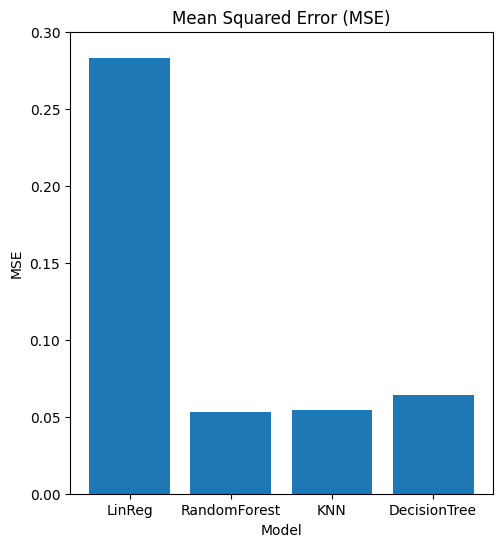

In [727]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(esg_table['Model'][1:-1], esg_table['MSE'][1:-1])
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.ylim((0, 0.3))

# Common ESG rating prediction based on HSE ESGify model

In [728]:
df_hse = pd.read_csv('HSE_weights_RAEX_full.csv')
df_hse.rename(columns={'Unnamed: 0' : 'Company name'}, inplace = True)
df_hse.set_index('Company name', inplace = True)
df_hse

,Инновации,Кибербезопасность,Персонал в целом,Биоразнообразие,Вода,Воздух,Заинтересованные стороны,Закупки и антикоррупция,Климат,Коренные народы и местные сообщ,...,Энергия,Этика и антикоррупция,Y,ESG-рейтинг,E Rank,E-рейтинг,S Rank,S-рейтинг,G Rank,G-рейтинг
Company name,,,,,,,,,,,,,,,,,,,,,
фосагро,-266892.0,-275193.0,-280915.0,-284643.0,-285278.0,-286335.0,-289479.0,-291162.0,-294029.0,-294138.0,...,-316996.0,-317000.0,2,0.833333,5,0.833333,3,0.833333,2,0.944444
магнит,-61487.0,-63261.0,-64290.0,-65958.0,-66621.0,-66742.0,-66941.0,-67670.0,-68250.0,-68263.0,...,-73870.0,-73870.0,79,0.277778,55,0.277778,81,0.277778,105,0.277778
русгидро,-210147.0,-216405.0,-218729.0,-220346.0,-223061.0,-228447.0,-229520.0,-230808.0,-232077.0,-233773.0,...,-250387.0,-250390.0,37,0.500000,29,0.500000,55,0.388889,24,0.722222
глобалтранс,-46171.0,-46530.0,-50250.0,-50580.0,-51251.0,-51591.0,-52416.0,-52657.0,-52820.0,-52939.0,...,-57160.0,-57160.0,63,0.388889,65,0.166667,74,0.277778,51,0.611111
афк система,-226477.0,-240278.0,-242562.0,-243634.0,-247022.0,-249914.0,-252214.0,-252304.0,-252946.0,-253824.0,...,-274205.0,-274210.0,67,0.388889,109,0.055556,86,0.277778,40,0.611111
втб,-198747.0,-203425.0,-203611.0,-206574.0,-208785.0,-212839.0,-213278.0,-214930.0,-215370.0,-216112.0,...,-232606.0,-232610.0,82,0.277778,107,0.055556,85,0.277778,77,0.388889
ммк,-254537.0,-263400.0,-263909.0,-264348.0,-269053.0,-274214.0,-275422.0,-276006.0,-276216.0,-276827.0,...,-299366.0,-299370.0,15,0.722222,8,0.722222,9,0.833333,27,0.722222
positive technologies,-54853.0,-55801.0,-56030.0,-58341.0,-60495.0,-61211.0,-62481.0,-63007.0,-63041.0,-63145.0,...,-67670.0,-67670.0,75,0.277778,148,0.055556,78,0.277778,61,0.500000
интер рао,-84942.0,-94360.0,-97619.0,-98970.0,-99080.0,-99193.0,-100802.0,-101561.0,-101601.0,-103066.0,...,-110070.0,-110070.0,25,0.611111,27,0.500000,33,0.611111,22,0.722222


In [729]:
TO_NORM = True
TO_Z_NORM = True

target = 'ESG-рейтинг'
print(merged_df.columns)
X = df_hse.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'E-рейтинг', 'S-рейтинг', 'G-рейтинг'])

if TO_NORM: # Как показала практика, нормировка дает абсолютно такой же результат. Поэтому не нормируем.
    min_values = X.min()
    max_values = X.max()

    for col in X.columns:
        X[col] = (X[col] - min_values[col]) / (max_values[col] - min_values[col])
if TO_Z_NORM:

    mean_values = X.mean()
    std_dev_values = X.std()
    for col in X.columns:
        X[col] = (X[col] - mean_values[col]) / std_dev_values[col]

y = df_hse[target]

rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True, stratify=y)


Index(['Legal Proceedings & Law Violations', 'Biodiversity',
       'Communities Health and Safety',
       'Land Acquisition and Resettlement (S)', 'Emergencies (Social)',
       'Corporate Governance', 'Responsible Investment & Greenwashing',
       'Not Relevant to ESG', 'Economic Crime', 'Emergencies (Environmental)',
       'Hazardous Materials Management', 'Environmental Management',
       'Landscape Transformation', 'Human Rights', 'Climate Risks',
       'Labor Relations Management',
       'Freedom of Association and Right to Organise',
       'Employee Health and Safety', 'Surface Water Pollution',
       'Animal Welfare', 'Water Consumption', 'Disclosure',
       'Product Safety and Quality', 'Greenhouse Gas Emissions',
       'Indigenous People', 'Cultural Heritage', 'Air Pollution',
       'Waste Management', 'Soil and Groundwater Impact', 'Forced Labour',
       'Wastewater Management', 'Natural Resources', 'Physical Impacts',
       'Values and Ethics', 'Risk Management

In [730]:
X

,Инновации,Кибербезопасность,Персонал в целом,Биоразнообразие,Вода,Воздух,Заинтересованные стороны,Закупки и антикоррупция,Климат,Коренные народы и местные сообщ,...,Сотрудники. Здоровье и благопол,Сотрудники. Корпоративная культ,Сотрудники. Наем и увольнение,Сотрудники. Профсоюз и Коллекти,Социальные инвестиции и благотв,Устойчивое развитие,Экологичность продукта,Экология в целом,Энергия,Этика и антикоррупция
Company name,,,,,,,,,,,,,,,,,,,,,
фосагро,-1.274977,-1.271724,-1.314934,-1.331777,-1.302830,-1.268527,-1.285597,-1.286622,-1.303842,-1.296246,...,-1.292838,-1.290838,-1.290264,-1.288672,-1.293206,-1.293350,-1.293301,-1.293284,-1.293289,-1.293299
магнит,1.102623,1.109965,1.114034,1.107700,1.110990,1.124792,1.131262,1.127136,1.123929,1.127773,...,1.114552,1.116461,1.117951,1.117987,1.118078,1.118044,1.118046,1.118078,1.118085,1.118081
русгидро,-0.618143,-0.611065,-0.617657,-0.614530,-0.615998,-0.637612,-0.634417,-0.634787,-0.637681,-0.648428,...,-0.629573,-0.629281,-0.634239,-0.632115,-0.632613,-0.632635,-0.632653,-0.632624,-0.632647,-0.632656
глобалтранс,1.279909,1.297987,1.271461,1.279245,1.280664,1.289921,1.289010,1.289279,1.289846,1.292226,...,1.280369,1.282324,1.282754,1.283025,1.283819,1.283830,1.283810,1.283813,1.283818,1.283812
афк система,-0.807166,-0.879350,-0.884891,-0.874313,-0.880511,-0.871579,-0.880883,-0.866948,-0.862082,-0.863609,...,-0.859748,-0.871135,-0.868925,-0.869231,-0.868826,-0.868842,-0.868897,-0.868879,-0.868879,-0.868905
втб,-0.486186,-0.465196,-0.448142,-0.460901,-0.458401,-0.467503,-0.458021,-0.463302,-0.458032,-0.458895,...,-0.452980,-0.456511,-0.456623,-0.454789,-0.456280,-0.456345,-0.456306,-0.456297,-0.456292,-0.456313
ммк,-1.131965,-1.139194,-1.124250,-1.105382,-1.123718,-1.136422,-1.132932,-1.122934,-1.112301,-1.110470,...,-1.114736,-1.116921,-1.118606,-1.118934,-1.118369,-1.118369,-1.118442,-1.118424,-1.118431,-1.118443
positive technologies,1.179413,1.193800,1.206651,1.192670,1.178616,1.185074,1.179699,1.177497,1.179941,1.182698,...,1.175703,1.178469,1.178438,1.178324,1.179574,1.179597,1.179619,1.179572,1.179577,1.179573
интер рао,0.831128,0.760475,0.740323,0.739445,0.752665,0.771112,0.763517,0.761106,0.765310,0.754279,...,0.756838,0.757498,0.758185,0.757508,0.759033,0.759057,0.759043,0.759035,0.759045,0.759047


In [731]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'RAEX values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,RAEX values,0,0,0.388889,0.611111,0.277778,0.5,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333


In [732]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])

    #уберем совсем плохие значения - что меньше 0 и больше 1
    y_pred[y_pred < 0] = 0
    y_pred[y_pred > 1] = 1

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.18933082401258453
R^2 Score: -3.0073725099140165


In [733]:
%time
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]

model = RandomForestRegressor(random_state=42)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [20],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

#print("Лучшие параметры: ", grid_search.best_params_)
#Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}
#Mean Squared Error: 0.05508845985402971
for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    #print("Лучшие параметры: ", grid_search.best_params_)
    # Оценка модели
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Mean Squared Error: 0.04876503874884282
R^2 Score: -0.028145305158171884


In [734]:
param_grid_try = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'euclidean', 'manhattan'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
# Оценка модели
for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    #print("Лучшие параметры: ", grid_search.best_params_)
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.047398148148148155
R^2 Score: 0.07710336538461526


In [735]:
param_grid_try = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [10, 15, 20, 50],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'max_features': ['sqrt'],
}
# Определение параметров для поиска
param_grid = {
    'max_depth': [None],
    'min_samples_split': [50],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
}

model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    #print("Лучшие параметры: ", grid_search.best_params_)
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.05148148148148148
R^2 Score: -0.0024038461538460343
[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
 0.53333333 0.53333333 0.53333333 0.53333333]


In [736]:
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [737]:
esg_table_hse = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,RAEX values,0,0,0.388889,0.611111,0.277778,0.500000,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333
1,LinReg,0.189331,-3.007373,0.902628,1.000000,0.094883,0.000000,0.000000,0.211463,0.000000,0.568272,1.000000,0.632843
2,RandomForest,0.048765,-0.028145,0.566743,0.566743,0.534610,0.553449,0.518211,0.537940,0.537940,0.566743,0.566743,0.537940
3,KNN,0.047398,0.077103,0.566667,0.566667,0.511111,0.561111,0.511111,0.511111,0.511111,0.566667,0.566667,0.511111
4,DecisionTree,0.051481,-0.002404,0.533333,0.533333,0.533333,0.533333,0.533333,0.533333,0.533333,0.533333,0.533333,0.533333
5,CoolMonkey,0.051674,-0.006154,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


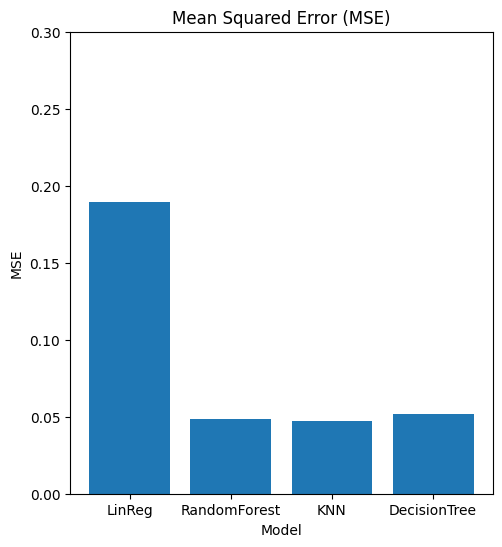

In [738]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(esg_table_hse['Model'][1:-1], esg_table_hse['MSE'][1:-1])
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.ylim((0, 0.3))
plt.show()

# E rating HSE model

In [739]:
X.columns
E_topics = ['Инновации', 'Биоразнообразие', 'Вода', 'Воздух',
       'Климат', 'Коренные народы и местные сообщ', 'Отходы и циклическая экономика', 'Поставщики в целом',  'Поставщики. Экология',
        'Потребители. Здоровье и благопо', 'Потребители. Качество и безопас', 'Рекультивация земель', 'Риски',
       'Сотрудники. Здоровье и благопол', 'Экологичность продукта', 'Экология в целом', 'Энергия']

S_topics = ['Персонал в целом',
       'Коренные народы и местные сообщ',
       'Лидерство', 'Обучение и развитие',
       'Оплата труда', 'Поставщики. Работники',
       'Потребители. Доступность', 'Потребители. Сервис и коммуника',
       'Потребители. Удовлетворенность', 'Потребители. Ценовая политика',
       'Права человека',
       'Сотрудники. Безопасность и охра', 'Сотрудники. Вовлеченность и мот',
       'Сотрудники. Волонтерство', 'Сотрудники. Здоровье и благопол',
       'Сотрудники. Корпоративная культ', 'Сотрудники. Наем и увольнение',
       'Сотрудники. Профсоюз и Коллекти', 'Социальные инвестиции и благотв']

G_topics = ['Инновации', 'Кибербезопасность', 'Заинтересованные стороны', 'Закупки и антикоррупция', 'Корпоративное управление',
            'Лидерство', 'Малый и локальный бизнес', 'Потребители. Маркетинг, продажи', 'Отчетность и прозрачность', 'Риски', 'Этика и антикоррупция',
            'Отношения с инвесторами']


In [740]:
TO_NORM =                  True
TO_Z_NORM =                True
DROP_NON_RELEVANT_TOPICS = True

target = 'E-рейтинг'
if DROP_NON_RELEVANT_TOPICS:
    X = df_hse.loc[:, E_topics]
else:
    X = df_hse.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'E-рейтинг', 'S-рейтинг', 'G-рейтинг'])

if TO_NORM:
    min_values = X.min()
    max_values = X.max()

    for col in X.columns:
        X[col] = (X[col] - min_values[col]) / (max_values[col] - min_values[col])
if TO_Z_NORM:

    mean_values = X.mean()
    std_dev_values = X.std()
    for col in X.columns:
        X[col] = (X[col] - mean_values[col]) / std_dev_values[col]

y = df_hse[target]

rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True, stratify=y)


In [741]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'E values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0,0,0.277778,0.388889,0.166667,0.277778,0.5,0.055556,0.055556,0.611111,0.833333,0.722222


In [742]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])

    #уберем совсем плохие значения - что меньше 0 и больше 1
    y_pred[y_pred < 0] = 0
    y_pred[y_pred > 1] = 1

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.14597413795364922
R^2 Score: -1.2023930593403536


In [743]:
%time
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]

model = RandomForestRegressor(random_state=42)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [15],
    'max_depth': [None],
    'min_samples_split': [20],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 184 µs
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучши

In [744]:
param_grid_try = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'euclidean', 'manhattan'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)

    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Mean Squared Error: 0.06896296296296298
R^2 Score: -0.0344444444444445


In [745]:
param_grid_try = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [10, 15, 20, 50],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'max_features': ['sqrt'],
}

param_grid = {
    'max_depth': [None],
    'min_samples_split': [50],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
}

model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Л

In [746]:
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [747]:
e_table_hse = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0,0,0.277778,0.388889,0.166667,0.277778,0.500000,0.055556,0.055556,0.611111,0.833333,0.722222
1,LinReg,0.145974,-1.202393,0.232349,0.363204,0.000000,1.000000,0.248444,0.354918,0.359383,0.460834,0.254084,0.000000
2,RandomForest,0.073355,-0.106193,0.437704,0.437704,0.437704,0.458445,0.415191,0.437704,0.415191,0.396228,0.458445,0.437704
3,KNN,0.068963,-0.034444,0.488889,0.477778,0.455556,0.455556,0.438889,0.450000,0.438889,0.438889,0.477778,0.477778
4,DecisionTree,0.068642,-0.02963,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333
5,CoolMonkey,0.089501,-0.342519,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


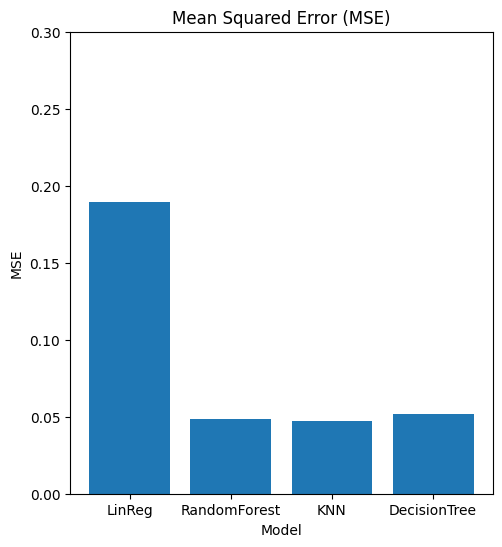

In [748]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(esg_table_hse['Model'][1:-1], esg_table_hse['MSE'][1:-1])
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.ylim((0, 0.3))
plt.show()

# S rating HSE model

In [749]:
TO_NORM =                  True
TO_Z_NORM =                True
DROP_NON_RELEVANT_TOPICS = True

target = 'S-рейтинг'
if DROP_NON_RELEVANT_TOPICS:
    X = df_hse.loc[:, S_topics]
else:
    X = df_hse.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'ESG-рейтинг', 'E-рейтинг', 'G-рейтинг'])

if TO_NORM:
    min_values = X.min()
    max_values = X.max()

    for col in X.columns:
        X[col] = (X[col] - min_values[col]) / (max_values[col] - min_values[col])
if TO_Z_NORM:

    mean_values = X.mean()
    std_dev_values = X.std()
    for col in X.columns:
        X[col] = (X[col] - mean_values[col]) / std_dev_values[col]

y = df_hse[target]

rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True)


In [750]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'S values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,S values,0,0,0.277778,0.833333,0.722222,0.722222,0.055556,0.722222,0.833333,0.166667,0.277778,0.5


In [751]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])
    #уберем совсем плохие значения - что меньше 0 и больше 1
    y_pred[y_pred < 0] = 0
    y_pred[y_pred > 1] = 1
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.09390890447643421
R^2 Score: -0.7839143749066725


In [752]:
%time
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]

model = RandomForestRegressor(random_state=42)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [15],
    'max_depth': [None],
    'min_samples_split': [20],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие

In [753]:
param_grid_try = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'euclidean', 'manhattan'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)

    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Mean Squared Error: 0.06975
R^2 Score: 0.10178855325914182


In [754]:
param_grid_try = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [10, 15, 20, 50],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'max_features': ['sqrt'],
}

param_grid = {
    'max_depth': [None],
    'min_samples_split': [50],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
}

model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Л

In [755]:
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [756]:
s_table_hse = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,S values,0,0,0.277778,0.833333,0.722222,0.722222,0.055556,0.722222,0.833333,0.166667,0.277778,0.500000
1,LinReg,0.093909,-0.783914,0.167891,0.433236,0.547919,0.528147,0.394180,0.443357,0.480190,0.417048,0.804532,0.564342
2,RandomForest,0.061773,-0.064223,0.578561,0.578561,0.562635,0.546178,0.546178,0.546178,0.578561,0.546178,0.546178,0.535375
3,KNN,0.06975,0.101789,0.538889,0.566667,0.533333,0.505556,0.500000,0.500000,0.572222,0.500000,0.500000,0.500000
4,DecisionTree,0.078532,-0.011305,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741
5,CoolMonkey,0.078489,-0.010747,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


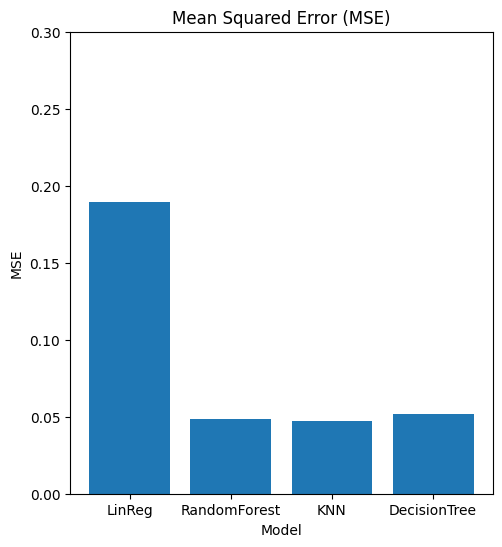

In [757]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(esg_table_hse['Model'][1:-1], esg_table_hse['MSE'][1:-1])
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.ylim((0, 0.3))
plt.show()

# G rating HSE model

In [758]:
TO_NORM =                  True
TO_Z_NORM =                True
DROP_NON_RELEVANT_TOPICS = True

target = 'E-рейтинг'
if DROP_NON_RELEVANT_TOPICS:
    X = df_hse.loc[:, G_topics]
else:
    X = df_hse.drop(columns=[target, 'Y', 'E Rank', 'S Rank', 'G Rank',
                                         'ESG-рейтинг', 'S-рейтинг', 'E-рейтинг'])

if TO_NORM:
    min_values = X.min()
    max_values = X.max()

    for col in X.columns:
        X[col] = (X[col] - min_values[col]) / (max_values[col] - min_values[col])
if TO_Z_NORM:

    mean_values = X.mean()
    std_dev_values = X.std()
    for col in X.columns:
        X[col] = (X[col] - mean_values[col]) / std_dev_values[col]

y = df_hse[target]

rand_seed = 200
n_butches = 10

X_train = [None for _ in range(n_butches)]
X_test = [None for _ in range(n_butches)]
y_train = [None for _ in range(n_butches)]
y_test = [None for _ in range(n_butches)]

for i in range(n_butches):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=0.25, random_state=rand_seed * (i + 1), shuffle=True, stratify=y)


In [759]:
#сделаем красивую общую табличку с резами.
compare_table = pd.DataFrame(columns=['Model', 'MSE', 'R^2 score'] + [str(i) for i in range(len(y_test[-1]))])
new_row = pd.DataFrame({'Model': 'G values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], y_test[-1].values))}, index=[0])
compare_table = pd.concat([compare_table, new_row], ignore_index=True)
compare_table


,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,G values,0,0,0.277778,0.388889,0.166667,0.277778,0.5,0.055556,0.055556,0.611111,0.833333,0.722222


In [760]:
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]
for i in range(n_butches):
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train[i], y_train[i])

    y_pred = model.predict(X_test[i])
    #уберем совсем плохие значения - что меньше 0 и больше 1
    y_pred[y_pred < 0] = 0
    y_pred[y_pred > 1] = 1
    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('LinReg', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Mean Squared Error: 0.0719800268312183
R^2 Score: -0.08584965002077559


In [761]:
%time
mse = [0 for _ in range(n_butches)]
r2 = [0 for _ in range(n_butches)]

model = RandomForestRegressor(random_state=42)
param_grid_try = {
    'n_estimators': [10, 25, 50, 75, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
param_grid = {
    'n_estimators': [15],
    'max_depth': [None],
    'min_samples_split': [20],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['friedman_mse']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):

    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)

    mse[i] = mean_squared_error(y_test[i], y_pred)
    r2[i] = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('RandomForest', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие параметры:  {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
Лучшие

In [762]:
param_grid_try = {
    'n_neighbors': [1, 5, 10, 15, 20, 25, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['chebyshev', 'euclidean', 'manhattan'],
}
param_grid = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['chebyshev'],
}
model = KNeighborsRegressor()
model.fit(X_train[-1], y_train[-1])

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)

    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")

new_row = add_row_res('KNN', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Лучшие параметры:  {'metric': 'chebyshev', 'n_neighbors': 20, 'weights': 'uniform'}
Mean Squared Error: 0.06869444444444446
R^2 Score: -0.03041666666666676


In [763]:
param_grid_try = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [10, 15, 20, 50],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'max_features': ['sqrt'],
}

param_grid = {
    'max_depth': [None],
    'min_samples_split': [50],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
}

model = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

for i in range(n_butches):
    grid_search.fit(X_train[i], y_train[i])
    y_pred = grid_search.predict(X_test[i])
    print("Лучшие параметры: ", grid_search.best_params_)
    mse = mean_squared_error(y_test[i], y_pred)
    r2 = r2_score(y_test[i], y_pred)

print(f"Mean Squared Error: {np.mean(mse)}")
print(f"R^2 Score: {np.mean(r2)}")
print(y_pred)

new_row = add_row_res('DecisionTree', np.mean(mse), np.mean(r2), y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Лучшие параметры:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50}
Л

In [764]:
y_pred = [0.54 for i in range(len(y_test[-1]))]

mse = mean_squared_error(y_test[-1], y_pred)
r2 = r2_score(y_test[-1], y_pred)

new_row = add_row_res('CoolMonkey', mse, r2, y_pred)
compare_table = pd.concat([compare_table, new_row], ignore_index=True)

In [765]:
g_table_hse = compare_table
compare_table

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,G values,0,0,0.277778,0.388889,0.166667,0.277778,0.500000,0.055556,0.055556,0.611111,0.833333,0.722222
1,LinReg,0.07198,-0.08585,0.000000,0.071506,0.000000,0.277286,0.402013,0.555471,0.480086,0.692495,1.000000,0.259671
2,RandomForest,0.073032,-0.101335,0.437828,0.437828,0.437828,0.458569,0.426055,0.437828,0.413710,0.394747,0.458569,0.437828
3,KNN,0.068694,-0.030417,0.488889,0.461111,0.455556,0.455556,0.438889,0.450000,0.438889,0.438889,0.477778,0.477778
4,DecisionTree,0.068642,-0.02963,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333
5,CoolMonkey,0.089501,-0.342519,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


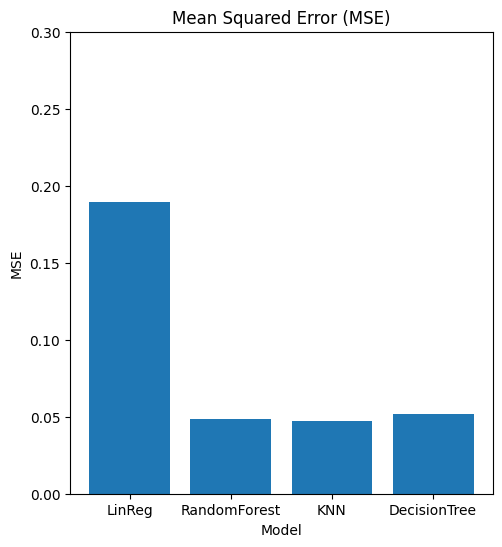

In [766]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(esg_table_hse['Model'][1:-1], esg_table_hse['MSE'][1:-1])
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.ylim((0, 0.3))
plt.show()

# Summary ESG HSE

In [767]:
e_table_hse

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0,0,0.277778,0.388889,0.166667,0.277778,0.500000,0.055556,0.055556,0.611111,0.833333,0.722222
1,LinReg,0.145974,-1.202393,0.232349,0.363204,0.000000,1.000000,0.248444,0.354918,0.359383,0.460834,0.254084,0.000000
2,RandomForest,0.073355,-0.106193,0.437704,0.437704,0.437704,0.458445,0.415191,0.437704,0.415191,0.396228,0.458445,0.437704
3,KNN,0.068963,-0.034444,0.488889,0.477778,0.455556,0.455556,0.438889,0.450000,0.438889,0.438889,0.477778,0.477778
4,DecisionTree,0.068642,-0.02963,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333
5,CoolMonkey,0.089501,-0.342519,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


In [768]:
s_table_hse

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,S values,0,0,0.277778,0.833333,0.722222,0.722222,0.055556,0.722222,0.833333,0.166667,0.277778,0.500000
1,LinReg,0.093909,-0.783914,0.167891,0.433236,0.547919,0.528147,0.394180,0.443357,0.480190,0.417048,0.804532,0.564342
2,RandomForest,0.061773,-0.064223,0.578561,0.578561,0.562635,0.546178,0.546178,0.546178,0.578561,0.546178,0.546178,0.535375
3,KNN,0.06975,0.101789,0.538889,0.566667,0.533333,0.505556,0.500000,0.500000,0.572222,0.500000,0.500000,0.500000
4,DecisionTree,0.078532,-0.011305,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741,0.540741
5,CoolMonkey,0.078489,-0.010747,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


In [769]:
g_table_hse

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,G values,0,0,0.277778,0.388889,0.166667,0.277778,0.500000,0.055556,0.055556,0.611111,0.833333,0.722222
1,LinReg,0.07198,-0.08585,0.000000,0.071506,0.000000,0.277286,0.402013,0.555471,0.480086,0.692495,1.000000,0.259671
2,RandomForest,0.073032,-0.101335,0.437828,0.437828,0.437828,0.458569,0.426055,0.437828,0.413710,0.394747,0.458569,0.437828
3,KNN,0.068694,-0.030417,0.488889,0.461111,0.455556,0.455556,0.438889,0.450000,0.438889,0.438889,0.477778,0.477778
4,DecisionTree,0.068642,-0.02963,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333,0.433333
5,CoolMonkey,0.089501,-0.342519,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000


In [770]:
combined_df_hse = pd.concat([E_table, S_table, G_table], ignore_index=True)
combined_df_hse = combined_df_hse.groupby('Model').mean()
combined_df_hse.sort_values(by='MSE', inplace=True)
combined_df_hse.reset_index(inplace=True)
new_row = pd.DataFrame({'Model': 'RAEX values', 'MSE': 0, 'R^2 score': 0, **dict(zip(compare_table.columns[3:], sample_y_test.values))}, index=[0])
combined_df_hse = pd.concat([combined_df_hse, new_row], ignore_index=True)


true_values = combined_df_hse.iloc[-1]

model_columns = combined_df_hse.columns[3:]  # Assuming the first two columns are not part of the model's predictions
# Calculate the MSE for each row based on the first row as true values
combined_df_hse['MSE'] = (combined_df_hse[model_columns] - true_values[model_columns]).pow(2).mean(axis=1)
combined_df_hse

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0.085185,0.0,0.833333,0.722222,0.166667,0.277778,0.833333,0.055556,0.500000,0.500000,0.277778,0.722222
1,G values,0.08642,0.0,0.833333,0.833333,0.388889,0.833333,0.944444,0.388889,0.722222,0.722222,0.611111,0.722222
2,S values,0.051852,0.0,0.833333,0.833333,0.277778,0.722222,0.944444,0.277778,0.388889,0.611111,0.611111,0.833333
3,CoolMonkey,0.051674,-0.33592,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000
4,KNN,0.056978,-0.269874,0.472222,0.524074,0.507407,0.481481,0.509259,0.500000,0.538889,0.466667,0.485185,0.490741
5,RandomForest,0.057068,-0.393736,0.521232,0.486555,0.486630,0.464992,0.501044,0.555841,0.553157,0.510725,0.507418,0.512324
6,DecisionTree,0.059633,-0.695162,0.490741,0.627866,0.444444,0.575397,0.450617,0.314815,0.563492,0.312169,0.498236,0.538066
7,LinReg,0.445089,-9.106793,1.077259,-0.820040,0.452456,0.618083,0.461534,0.599420,0.325127,0.079830,-0.095432,1.510221
8,RAEX values,0.0,0,0.388889,0.611111,0.277778,0.500000,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333


In [771]:
combined_df_hse

,Model,MSE,R^2 score,0,1,2,3,4,5,6,7,8,9
0,E values,0.085185,0.0,0.833333,0.722222,0.166667,0.277778,0.833333,0.055556,0.500000,0.500000,0.277778,0.722222
1,G values,0.08642,0.0,0.833333,0.833333,0.388889,0.833333,0.944444,0.388889,0.722222,0.722222,0.611111,0.722222
2,S values,0.051852,0.0,0.833333,0.833333,0.277778,0.722222,0.944444,0.277778,0.388889,0.611111,0.611111,0.833333
3,CoolMonkey,0.051674,-0.33592,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000,0.540000
4,KNN,0.056978,-0.269874,0.472222,0.524074,0.507407,0.481481,0.509259,0.500000,0.538889,0.466667,0.485185,0.490741
5,RandomForest,0.057068,-0.393736,0.521232,0.486555,0.486630,0.464992,0.501044,0.555841,0.553157,0.510725,0.507418,0.512324
6,DecisionTree,0.059633,-0.695162,0.490741,0.627866,0.444444,0.575397,0.450617,0.314815,0.563492,0.312169,0.498236,0.538066
7,LinReg,0.445089,-9.106793,1.077259,-0.820040,0.452456,0.618083,0.461534,0.599420,0.325127,0.079830,-0.095432,1.510221
8,RAEX values,0.0,0,0.388889,0.611111,0.277778,0.500000,0.611111,0.277778,0.166667,0.722222,0.833333,0.833333
